In [1]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/177.1 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.1 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.1/2.1 MB 86.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.6 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('exam_dataset_50k.csv')

/tmp/ipython-input-1033/3095725691.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('exam_dataset_50k.csv')


In [4]:
# Install necessary libraries
!pip install xgboost scikit-learn pandas matplotlib seaborn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import xgboost as xgb

In [6]:
# Load the dataset
df = pd.read_csv("/content/exam_dataset_50k.csv", low_memory=False)
print(f"Loaded: {df.shape[0]:,} rows x {df.shape[1]} columns\n")

Loaded: 50,000 rows x 68 columns



In [7]:
# Available when a question is written -- before any student sees it
TEXT_FEATURES = [
    "text_length", "word_count", "sentence_count", "avg_word_length",
    "latex_command_count", "has_latex", "latex_density",
    "math_operator_count", "number_count", "vocab_richness",
    "text_complexity_score",
    "answer_a_length", "answer_b_length", "answer_c_length", "answer_d_length",
    "avg_answer_length", "answer_length_variance",
    "has_advanced_terms", "has_algebra_terms",
    "has_geometry_terms", "has_stats_terms",
    "num_misconceptions", "has_misconception",
    "subject_difficulty_tier", "construct_frequency",
]

# Available after the first exam sitting, but never directly encoding p-value
POST_ADMIN_FEATURES = TEXT_FEATURES + [
    "avg_response_time_sec",
    "std_response_time_sec",
    "discrimination_index",
    "point_biserial_corr",
    "irt_a_param",
]

In [8]:
# Define regression and classification targets
REG_TARGET = "difficulty_p_value"    # continuous
CLF_TARGET = "difficulty_label"      # Easy / Medium / Hard

y_reg = df[REG_TARGET].astype(float)

le = LabelEncoder()
y_clf = le.fit_transform(df[CLF_TARGET])
CLASS_NAMES = le.classes_
N_CLASSES   = len(CLASS_NAMES)

print("Classes :", list(CLASS_NAMES))
print("Counts  :", {c: int((y_clf==i).sum()) for i,c in enumerate(CLASS_NAMES)})

Classes : ['Easy', 'Hard', 'Medium']
Counts  : {'Easy': 39189, 'Hard': 1740, 'Medium': 9071}


In [9]:
# Shared XGBoost parameters for regression and classification
XGB_PARAMS_REG = dict(
    n_estimators     = 400,
    learning_rate    = 0.05,
    max_depth        = 6,
    subsample        = 0.8,
    colsample_bytree = 0.8,
    reg_alpha        = 0.1,
    reg_lambda       = 1.0,
    random_state     = 42,
    n_jobs           = -1,
    verbosity        = 0,
)

XGB_PARAMS_CLF = dict(
    **XGB_PARAMS_REG,
    objective         = "multi:softprob",
    num_class         = N_CLASSES,
    use_label_encoder = False,
    eval_metric       = "mlogloss",
)

results = {}   # Dictionary to store all metric dicts

# Task
Prepare and split the data using all features in `POST_ADMIN_FEATURES` for both regression and classification targets, then train an XGBoost Regressor and Classifier, evaluate their performance using appropriate metrics, and store these results in the `results` dictionary under key 'B'. Finally, perform 5-fold cross-validation for the XGBoost Classifier to obtain a robust accuracy estimate and print a classification report.

## Prepare Data with All Features

### Subtask:
Extract all features specified in `POST_ADMIN_FEATURES` from the DataFrame and split the data into training and testing sets for both regression and classification targets. This will be referred to as Scenario B.


**Reasoning**:
To prepare data for Scenario B, I need to create a new DataFrame `Xb` using the `POST_ADMIN_FEATURES` list and then split it, along with the regression and classification targets, into training and testing sets.



In [24]:
Xb = df[POST_ADMIN_FEATURES]
ybr = df[REG_TARGET]
ybc = y_clf

Xb_tr, Xb_te, ybr_tr, ybr_te, ybc_tr, ybc_te = train_test_split(
    Xb, ybr, ybc, test_size=0.2, random_state=42, stratify=ybc
)

print(f"Shape of Xb_tr: {Xb_tr.shape}")
print(f"Shape of Xb_te: {Xb_te.shape}")
print(f"Shape of ybr_tr: {ybr_tr.shape}")
print(f"Shape of ybr_te: {ybr_te.shape}")
print(f"Shape of ybc_tr: {ybc_tr.shape}")
print(f"Shape of ybc_te: {ybc_te.shape}")

Shape of Xb_tr: (40000, 30)
Shape of Xb_te: (10000, 30)
Shape of ybr_tr: (40000,)
Shape of ybr_te: (10000,)
Shape of ybc_tr: (40000,)
Shape of ybc_te: (10000,)


**Reasoning**:
Now that the data for Scenario B (all `POST_ADMIN_FEATURES`) is prepared and split, the next step is to train an XGBoost Regressor model using the training data (`Xb_tr`, `ybr_tr`) and evaluate its performance on the test data (`Xb_te`, `ybr_te`). This will provide the regression metrics for Scenario B.



In [25]:
 print('\n  [B-Reg] XGBoost Regressor ...')
b_reg = xgb.XGBRegressor(**XGB_PARAMS_REG)
b_reg.fit(Xb_tr, ybr_tr, eval_set=[(Xb_te, ybr_te)], verbose=False)

b_reg_pred = b_reg.predict(Xb_te)

b_mae  = mean_absolute_error(ybr_te, b_reg_pred)
b_rmse = np.sqrt(mean_squared_error(ybr_te, b_reg_pred))
b_r2   = r2_score(ybr_te, b_reg_pred)

print(f"    MAE={b_mae:.4f}  RMSE={b_rmse:.4f}  R2={b_r2:.4f}")


  [B-Reg] XGBoost Regressor ...
    MAE=0.0162  RMSE=0.0227  R2=0.9761


**Reasoning**:
The next step is to train an XGBoost Classifier model using the prepared training data for Scenario B (`Xb_tr`, `ybc_tr`) and evaluate its performance on the test data (`Xb_te`, `ybc_te`), calculating the accuracy, precision, recall, and F1-score.



In [26]:
print('  [B-Clf] XGBoost Classifier ...')
b_clf = xgb.XGBClassifier(**XGB_PARAMS_CLF)
b_clf.fit(Xb_tr, ybc_tr, eval_set=[(Xb_te, ybc_te)], verbose=False)
b_clf_pred  = b_clf.predict(Xb_te)
b_clf_proba = b_clf.predict_proba(Xb_te)

b_acc  = accuracy_score(ybc_te, b_clf_pred)
b_prec = precision_score(ybc_te, b_clf_pred, average="weighted", zero_division=0)
b_rec  = recall_score(ybc_te, b_clf_pred, average="weighted", zero_division=0)
b_f1   = f1_score(ybc_te, b_clf_pred, average="weighted", zero_division=0)
print(f"    Acc={b_acc:.4f}  Prec={b_prec:.4f}  Rec={b_rec:.4f}  F1={b_f1:.4f}")

  [B-Clf] XGBoost Classifier ...
    Acc=0.9534  Prec=0.9535  Rec=0.9534  F1=0.9532


**Reasoning**:
To get a more robust estimate of the classifier's performance, I will perform 5-fold stratified cross-validation on the XGBoost Classifier using the full dataset (`Xb`, `y_clf`).



In [27]:
print("  [B-CV]  5-Fold CV ...")
b_cv = cross_val_score(
    xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6,
                      use_label_encoder=False, eval_metric="mlogloss",
                      objective="multi:softprob", num_class=N_CLASSES,
                      random_state=42, n_jobs=-1, verbosity=0),
    Xb, y_clf, cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)
print(f"    CV Accuracy: {b_cv.mean():.4f} +/- {b_cv.std():.4f}")

  [B-CV]  5-Fold CV ...
    CV Accuracy: 0.9520 +/- 0.0025


**Reasoning**:
Now that all performance metrics for Scenario B (regression, classification, and cross-validation) have been calculated, I will store these results, along with the predicted values and feature importances, into the `results` dictionary under the key 'B' for later comparison and visualization. I will also print a comprehensive classification report for Scenario B.



In [28]:
results["B"] = dict(
    label="Post-Admin (All Features)", n_feat=len(POST_ADMIN_FEATURES),
    MAE=b_mae, RMSE=b_rmse, R2=b_r2,
    Acc=b_acc, Prec=b_prec, Rec=b_rec, F1=b_f1,
    CV=b_cv.mean(), CV_std=b_cv.std(),
    reg_pred=b_reg_pred, clf_pred=b_clf_pred, clf_proba=b_clf_proba,
    yr_te=ybr_te, yc_te=ybc_te,
    feat_imp_reg=b_reg.feature_importances_,
    feat_imp_clf=b_clf.feature_importances_,
    feat_names=np.array(POST_ADMIN_FEATURES),
)

print("\n  Full Classification Report (B):")
print(classification_report(ybc_te, b_clf_pred, target_names=CLASS_NAMES))


  Full Classification Report (B):
              precision    recall  f1-score   support

        Easy       0.98      0.98      0.98      7838
        Hard       0.90      0.75      0.82       348
      Medium       0.86      0.88      0.87      1814

    accuracy                           0.95     10000
   macro avg       0.91      0.87      0.89     10000
weighted avg       0.95      0.95      0.95     10000



## Generate Plots for All Features

### Subtask:
Generate plots similar to the 'Text-Only' scenario, visualizing the regression metrics, actual vs. predicted p-values, and the confusion matrix for the 'all features' models.


**Reasoning**:
I need to generate plots for the 'All Features (post-admin)' scenario (Scenario B) to visualize the regression metrics, actual vs. predicted p-values, and the confusion matrix. This step will follow the pattern established by the previous plotting cell for Scenario A, using `results["B"]` for the data and saving the output to `xgboost_results_B.png`.




Generating plots for Scenario B...
  Saved -> xgboost_results_B.png


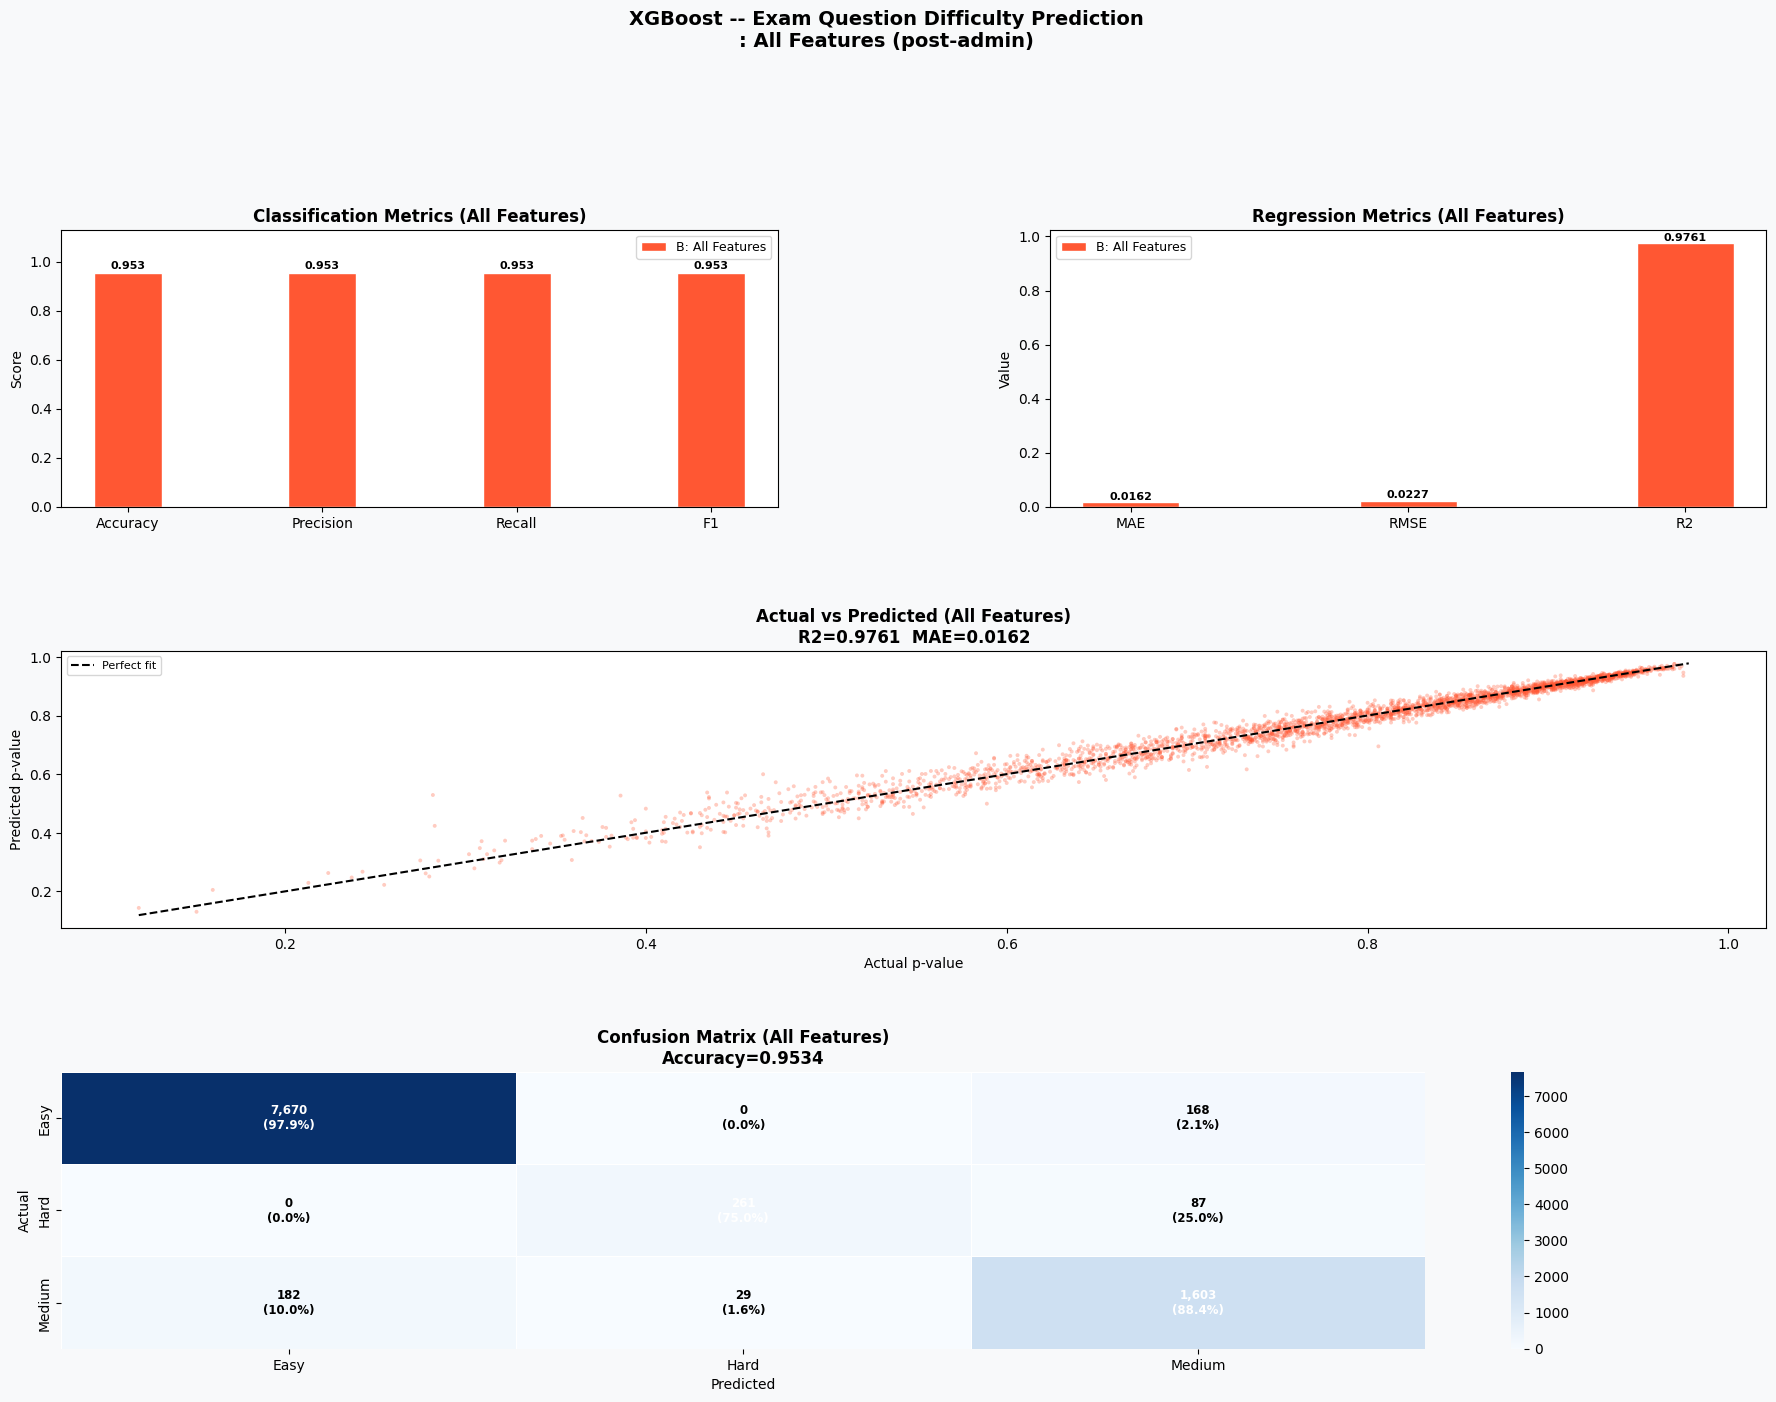

In [29]:
print("\nGenerating plots for Scenario B...")

fig = plt.figure(figsize=(22, 20))
fig.patch.set_facecolor("#F8F9FA")
fig.suptitle(
    "XGBoost -- Exam Question Difficulty Prediction\n: All Features (post-admin)",
    fontsize=14, fontweight="bold", y=0.99
)

COL_B = "#FF5733" # Distinct color for Scenario B
TOP   = 12

gs = fig.add_gridspec(4, 2, hspace=0.52, wspace=0.38)

# Row 0: metric comparison (Classification)
ax = fig.add_subplot(gs[0, 0])
clf_metrics_list = ["Accuracy", "Precision", "Recall", "F1"]
b_vals = [results["B"]["Acc"], results["B"]["Prec"], results["B"]["Rec"], results["B"]["F1"]]
x = np.arange(len(clf_metrics_list)); w = 0.35
b1 = ax.bar(x, b_vals, w, color=COL_B, label="B: All Features",  edgecolor="white")
ax.set_xticks(x); ax.set_xticklabels(clf_metrics_list)
ax.set_ylim(0, 1.13); ax.set_ylabel("Score")
ax.set_title("Classification Metrics (All Features)", fontweight="bold")
ax.legend(fontsize=9)
for bar in list(b1):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
            f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=8, fontweight="bold")

# Row 0: metric comparison (Regression)
ax = fig.add_subplot(gs[0, 1])
reg_m_names = ["MAE", "RMSE", "R2"]
rb_vals = [results["B"]["MAE"], results["B"]["RMSE"], results["B"]["R2"]]
x = np.arange(len(reg_m_names)); w = 0.35
b1 = ax.bar(x, rb_vals, w, color=COL_B, label="B: All Features",  edgecolor="white")
ax.set_xticks(x); ax.set_xticklabels(reg_m_names)
ax.set_ylabel("Value"); ax.set_title("Regression Metrics (All Features)", fontweight="bold")
ax.legend(fontsize=9)
for bar in list(b1):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.002,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=8, fontweight="bold")

# Row 1: Actual vs Predicted (Regression)
ax = fig.add_subplot(gs[1, 0:2]) # Span across 2 columns
r = results["B"]
sample = np.random.choice(len(r["yr_te"]), 3000, replace=False)
ax.scatter(r["yr_te"].values[sample], r["reg_pred"][sample],
           alpha=0.3, s=8, color=COL_B, edgecolors="none")
mn, mx = r["yr_te"].min(), r["yr_te"].max()
ax.plot([mn, mx], [mn, mx], "k--", lw=1.5, label="Perfect fit")
ax.set_xlabel("Actual p-value"); ax.set_ylabel("Predicted p-value")
ax.set_title(f"Actual vs Predicted (All Features)\nR2={r['R2']:.4f}  MAE={r['MAE']:.4f}", fontweight="bold")
ax.legend(fontsize=8)

# Row 2: Confusion matrices (Classification)
ax = fig.add_subplot(gs[2, 0:2]) # Span across 2 columns
r = results["B"]
cm = confusion_matrix(r["yc_te"], r["clf_pred"])
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax, linewidths=0.5, vmin=0, vmax=cm.max())
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        ax.text(j+0.5, i+0.5, f"{cm[i,j]:,}\n({cm_pct[i,j]:.1f}%)",
                ha="center", va="center", fontsize=8.5, fontweight="bold",
                color="white" if cm_pct[i,j] > 55 else "black")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_title(f"Confusion Matrix (All Features)\nAccuracy={r['Acc']:.4f}", fontweight="bold")

plt.savefig("xgboost_results_B.png", dpi=180, bbox_inches="tight", facecolor="#F8F9FA")
print("  Saved -> xgboost_results_B.png")

## Save Predictions and Models (All Features)

### Subtask:
Save the predictions from the 'all features' models to a CSV file and save the trained XGBoost Regressor and Classifier models for future use.


**Reasoning**:
I need to create a DataFrame with the actual and predicted values for both regression and classification for Scenario B, along with metadata, and then save it to a CSV file. After that, I will save the trained XGBoost Regressor and Classifier models for Scenario B to JSON files.



In [30]:
pd.DataFrame({
    "QuestionId":       df.loc[Xb_te.index, "QuestionId"].values,
    "SubjectName":      df.loc[Xb_te.index, "SubjectName"].values,
    "actual_p_value":   ybr_te.values.round(4),
    "xgb_pred_p_value": b_reg_pred.round(4),
    "actual_label":     le.inverse_transform(ybc_te),
    "xgb_pred_label":   le.inverse_transform(b_clf_pred),
    "correct":          (b_clf_pred == ybc_te).astype(int),
}).to_csv(f"xgboost_predictions_B.csv", index=False)
print(f"  Saved -> xgboost_predictions_B.csv")

b_reg.save_model('xgb_reg_model_B.json')
b_clf.save_model('xgb_clf_model_B.json')
print(f"  Saved -> xgb_reg_model_B.json")
print(f"  Saved -> xgb_clf_model_B.json")

  Saved -> xgboost_predictions_B.csv
  Saved -> xgb_reg_model_B.json
  Saved -> xgb_clf_model_B.json


In [ ]:

import joblib
from google.colab import files

joblib.dump(le, 'xg_pipeline.pkl')
files.download('xgb_reg_model_B.json')
files.download('xgb_clf_model_B.json')
files.download('xg_pipeline.pkl')